# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

In [1]:
from IPython.display import display, HTML   
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD

### Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
total_tr_len = len(cifar10_train)

X={}
Y=[]
for i in range(len(cifar10_train)):
    data = cifar10_train[i][0].numpy()
    label = cifar10_train[i][1]

    if label in X:
        X[label].append(data)
    else:
        X[label] = []
        X[label].append(data)
        Y.append(label)

for label in X:
    X[label] = np.array(X[label])
Y=np.array(Y)

alpha = 20
n_users = 50

In [5]:
user_train_data_non_tensors = [[] for _ in range(n_users)]
user_train_label_non_tensors = [[] for _ in range(n_users)]

for label in Y:
    alpha_list = [alpha for _ in range(n_users)]
    probs = np.random.dirichlet(alpha_list)

    taken_index = 0

    for i, prob in enumerate(probs):
        if i == n_users - 1:
            user_train_data_non_tensors[i].extend(X[label][taken_index:])
            user_train_label_non_tensors[i].extend([label for _ in range(len(X[label]) - taken_index)])
        else:
            n_sample = math.floor(prob * len(X[label]))

            user_train_data_non_tensors[i].extend(X[label][taken_index : taken_index + n_sample])
            user_train_label_non_tensors[i].extend([label for _ in range(n_sample)])
            taken_index += n_sample

user_train_data_tensors = []
user_train_label_tensors = []

user_tr_len = []

for i in range(n_users):

    if len(user_train_data_non_tensors[i]) != len(user_train_label_non_tensors[i]):
        sys.exit(f"Shape does not match user_train_data_non_tensors[i] hsa {len(user_train_data_non_tensors[i])}, while user_train_label_non_tensors[i] has {len(user_train_label_non_tensors[i])}")
   
    
    num_data = len(user_train_data_non_tensors[i])
    user_tr_len.append(num_data)

    user_train_data_tensors.append(torch.from_numpy(np.array(user_train_data_non_tensors[i])).type(torch.FloatTensor))
    user_train_label_tensors.append(torch.from_numpy(np.array(user_train_label_non_tensors[i])).type(torch.LongTensor))

    r=np.arange(num_data)
    
    np.random.shuffle(r)    

    user_train_data_tensors[i] = user_train_data_tensors[i][r]
    user_train_label_tensors[i] = user_train_label_tensors[i][r]

    print(f'user {i} has {user_train_data_tensors[i].shape[0]} train data, and {user_train_label_tensors[i].shape[0]} train labels')
    


user 0 has 1011 train data, and 1011 train labels
user 1 has 993 train data, and 993 train labels
user 2 has 1016 train data, and 1016 train labels
user 3 has 876 train data, and 876 train labels
user 4 has 932 train data, and 932 train labels
user 5 has 1120 train data, and 1120 train labels
user 6 has 975 train data, and 975 train labels
user 7 has 940 train data, and 940 train labels
user 8 has 983 train data, and 983 train labels
user 9 has 923 train data, and 923 train labels
user 10 has 1045 train data, and 1045 train labels
user 11 has 946 train data, and 946 train labels
user 12 has 1037 train data, and 1037 train labels
user 13 has 1062 train data, and 1062 train labels
user 14 has 829 train data, and 829 train labels
user 15 has 1082 train data, and 1082 train labels
user 16 has 1106 train data, and 1106 train labels
user 17 has 1034 train data, and 1034 train labels
user 18 has 1020 train data, and 1020 train labels
user 19 has 1080 train data, and 1080 train labels
user 20 

In [6]:
X2 = []
Y2 = []

for i in range(len(cifar10_test)):
    X2.append(cifar10_test[i][0].numpy())
    Y2.append(cifar10_test[i][1])

X2=np.array(X2)
Y2=np.array(Y2)

half_index = len(X2) // 2

val_data= X2[:half_index]
val_label= Y2[:half_index]

te_data=X2[half_index:]
te_label=Y2[half_index:]

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

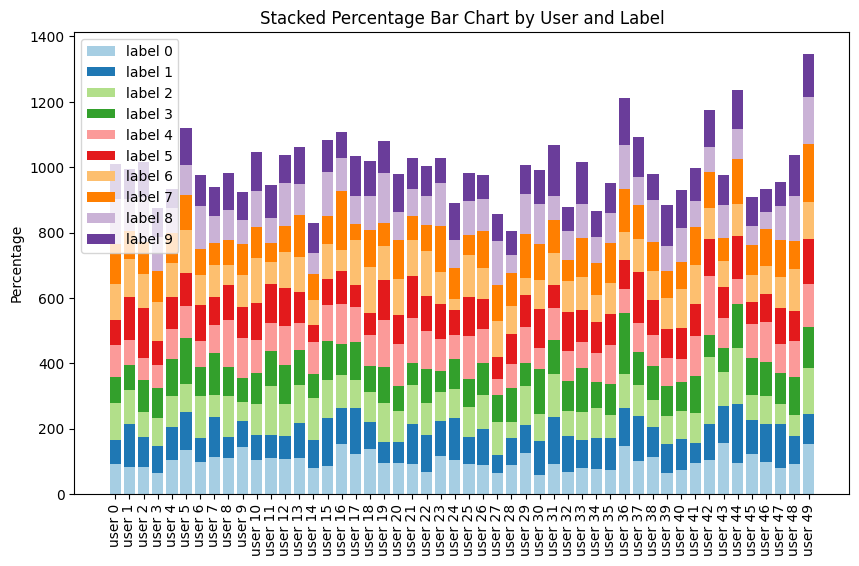

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Example data
users = [f"user {i}" for i in range(50)]
labels = [f"label {i}" for i in range(10)]


percentages = []
for user_data in user_train_label_non_tensors:
    temp_holder = []
    for label in range(10):
        temp_holder.append(user_data.count(label))
    percentages.append(temp_holder)

percentages = np.array(percentages)

# Assuming 'percentages' is populated correctly as shown previously
# Convert percentages to cumulative sum for stacking
cumulative = np.cumsum(percentages, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each ethnicity, ensuring there are enough colors for all labels
colors = plt.cm.Paired(range(len(labels))) # Repeating colors to match the number of labels

# Create stacked bars
for i in range(len(labels)):  # Iterate over the number of labels
    if i == 0:
        ax.bar(users, percentages[:, i], color=colors[i], label=labels[i])
    else:
        ax.bar(users, percentages[:, i], bottom=cumulative[:, i-1], color=colors[i], label=labels[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Stacked Percentage Bar Chart by User and Label')
ax.set_xticks(np.arange(len(users)))
ax.set_xticklabels(users, rotation=90)  # Rotate labels if needed
ax.legend()


plt.savefig('./non_iid_user_label_distribution.png', bbox_inches='tight')
plt.show()


## Our Aggregation Function

In [8]:
def our_mean_defense(all_updates, n_attackers, history_updates):
    # print(all_updates[0].shape)
    # update the history records
    if not history_updates:
       history_updates = [[] for _ in range(n_attackers)]
    updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)
    for i in range(n_attackers):
        history_updates[i].extend(updates_abs_mean[i])

    discarded_history = []
    for _ in range(n_attackers):
        sum_of_distances = []
        for i, row in enumerate(history_updates):
            if i in discarded_history:
                sum_of_distances.append(-1)
                continue
            distance_sum = 0
            for j, other_row in enumerate(history_updates): 
                if row != other_row and j not in discarded_history: 
                    distance_sum += euclidean_distance(row, other_row)
            sum_of_distances.append(distance_sum)
        max_distance = max(sum_of_distances) 
        index_of_max_distance = sum_of_distances.index(max_distance)
        discarded_history.append(index_of_max_distance)
    
    # get tensors in all_updates excluding the discarded ones
    mask = torch.ones(all_updates.size(0), dtype=torch.bool)  # Create a mask of ones (True)
    mask[discarded_history] = False  # Set indices in discarded_history to False
    remaining_updates = all_updates[mask]

    # returns the mean of selected updates 
    # print(torch.nanmean(remaining_updates, dim=0).shape)
    return torch.nanmean(remaining_updates, dim=0)
    

def euclidean_distance(row1, row2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(row1, row2)))


## Code for Bulyan aggregation algorithm

In [9]:
def bulyan(all_updates, n_attackers):
    n_users = all_updates.shape[0]
    bulyan_cluster = []
    candidate_indices = []
    remaining_updates = all_updates
    all_indices = np.arange(len(all_updates))

    while len(bulyan_cluster) < (n_users - 2 * n_attackers):
        torch.cuda.empty_cache()
        distances = []
        for update in remaining_updates:
            distance = []
            for update_ in remaining_updates:
                distance.append(torch.norm((update - update_)) ** 2)
            distance = torch.Tensor(distance).float()
            distances = distance[None, :] if not len(distances) else torch.cat((distances, distance[None, :]), 0)
        # print(distances)

        distances = torch.sort(distances, dim=1)[0]

        scores = torch.sum(distances[:, :len(remaining_updates) - 2 - n_attackers], dim=1)
        indices = torch.argsort(scores)[:len(remaining_updates) - 2 - n_attackers]
        if not len(indices):
            break
        candidate_indices.append(all_indices[indices[0].cpu().numpy()])
        all_indices = np.delete(all_indices, indices[0].cpu().numpy())
        bulyan_cluster = remaining_updates[indices[0]][None, :] if not len(bulyan_cluster) else torch.cat((bulyan_cluster, remaining_updates[indices[0]][None, :]), 0)
        remaining_updates = torch.cat((remaining_updates[:indices[0]], remaining_updates[indices[0] + 1:]), 0)

    # print('dim of bulyan cluster ', bulyan_cluster.shape)

    n, d = bulyan_cluster.shape
    param_med = torch.median(bulyan_cluster, dim=0)[0]
    sort_idx = torch.argsort(torch.abs(bulyan_cluster - param_med), dim=0)
    sorted_params = bulyan_cluster[sort_idx, torch.arange(d)[None, :]]

    return torch.mean(sorted_params[:n - 2 * n_attackers], dim=0), np.array(candidate_indices)

## our_attack_mean_std
$ argmin_\theta(\ -L(\theta_{attacker(s)}) + \lambda_1 |\bar{\theta_{abs\ mean\ benige\ users}} - \bar{\theta_{abs\ attacker(s)}}| + \lambda_2 |\bar{\sigma_{mean\ benige\ users}} - \bar{\sigma_{attacker(s)}}|)$

In [10]:
def our_attack_mean_std(all_updates, model_re, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors):
    
    all_updates_deviation = all_updates.std(dim=1, keepdim=True) # [50, 1]
    benign_std_avg = all_updates_deviation.mean() # [1, 1]

    all_updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)  # [50,1]
    benign_abs_mean_avg = all_updates_abs_mean.mean() # [1, 1]

    result_attacker_grads = [] 
    attacker_grads = all_updates[:n_attacker]


    for index, attacker_grad in enumerate(attacker_grads):

        attacker_tr_data_tensor = user_train_data_tensors[index].cuda()
        attacker_tr_label_tensor = user_train_label_tensors[index].cuda()

        # lambda1 = torch.tensor([10000]).cuda()
        # lambda2 = torch.tensor([10000]).cuda()

        def rosen(X):
            # lambda11 = X[0].cuda()
            # lambda22 = X[1].cuda()
            # X = X[2:]
            X = X.cuda()
            attacker_abs_mean = X.abs().mean()
            attacker_std = X.abs().std()
            # print(lambda11, lambda22)
            # Reshape X into the shape of fed_model.parameters
            fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
            optimizer_fed = SGD(fed_model.parameters(), lr=0.5)

            optimizer_fed.zero_grad()
            model_grads=[]
            start_idx = 0
            for i, param in enumerate(fed_model.parameters()):
                param_=X[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
                start_idx=start_idx+len(param.data.view(-1))
                param_=param_.cuda()
                model_grads.append(param_)
            optimizer_fed.step(model_grads)
            # print('model: ', -criterion(fed_model(attacker_tr_data_tensor), attacker_tr_label_tensor))
            # print('abs mean: ', torch.abs(benign_std_avg - attacker_abs_mean))
            return -criterion(fed_model(attacker_tr_data_tensor), attacker_tr_label_tensor) + 1*torch.abs(benign_std_avg - attacker_abs_mean) + 1*torch.abs(benign_abs_mean_avg - attacker_std)
        
        from torchmin import minimize

        res = minimize(
            # rosen, torch.cat((lambda1, lambda2, attacker_grad)), 
            rosen, attacker_grad, 
            method='l-bfgs', 
            options=dict(line_search='strong-wolfe'),
            max_iter=100,
            disp=False
        )
        nan_indices = torch.where(torch.isnan(res.grad)==True)
        # result_attacker_grads.append(res.grad[2:])
        result_attacker_grads.append(res.grad)

    return torch.stack(result_attacker_grads).cuda()

## Execute our attack + 10 attacker + our defense

In [12]:
batch_size=250
resume=0

nepochs= 50

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size
            # nbatches = 1000//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            # inputs = user_train_data_tensors[i]
            # targets = user_train_label_tensors[i]

            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                # print(param.shape)
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)
        
        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])
        
        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)

        if  torch.isnan(updates_abs_mean).any():
            print("updates_abs_mean contains a nan value")
            print("-----------------------BEFORE-----------------------------------")
            nan_indices = torch.where(torch.isnan(updates_abs_mean))
            print("updates_abs_mean has nan value at these index: ", nan_indices)
            user_grad_nan_index = torch.where(user_grads[nan_indices[0]])
            print("user_grads has nan value at these index", user_grad_nan_index)
            print(user_grads[nan_indices[0]][user_grad_nan_index])
        
        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//n_users)
            agg_grads = torch.mean(user_grads[:n_attacker], 0)

            # No attack
            # malicious_grads = user_grads

            # Attack
            mal_updates = our_attack_mean_std(user_grads, agg_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            
            # updates_abs_mean = mal_updates.abs().mean(dim=1, keepdim=True)

            # if  torch.isnan(updates_abs_mean).any():
            #     print(updates_abs_mean)
            #     print("-----------------------HERE-----------------------------------")
            #     print("updates_abs_mean contains a nan value")
            #     nan_indices = torch.where(torch.isnan(updates_abs_mean.grad))
            #     print("updates_abs_mean has nan value at these index: ", nan_indices)

            #     user_grad_nan_index = torch.where(user_grads[nan_indices[0]])
            #     print("user_grads has nan value at these index", user_grad_nan_index)
            #     print(user_grads[nan_indices[0]][user_grad_nan_index])

            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])

        # malicious_grads = user_grads
        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
        
        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)
        

        if  torch.isnan(updates_abs_mean).any():
            print("-----------------------AFTER-----------------------------------")
            print("updates_abs_mean contains a nan value")
            nan_indices = torch.where(torch.isnan(updates_abs_mean))
            print("updates_abs_mean has nan value at these index: ", nan_indices)
            user_grad_nan_index = torch.where(user_grads[nan_indices[0]])
            print("user_grads has nan value at these index", user_grad_nan_index)
            print(user_grads[nan_indices[0]][user_grad_nan_index])
 
        for i in range(n_users):
            history[i].extend(updates_abs_mean[i])        

        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        # print(malicious_grads.abs().mean(dim=1, keepdim=True))
        # print(history[0])
        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no_attack.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

epoch: 0, bulyan: at our-agr n_at 10 e 0 | val loss 2.3025 val acc 13.8596 best val_acc 13.859578


C:\Users\Hizan\AppData\Local\Temp\ipykernel_12224\1762673570.py:174: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


epoch: 1, bulyan: at our-agr n_at 10 e 1 | val loss 2.3020 val acc 13.0885 best val_acc 13.859578
epoch: 2, bulyan: at our-agr n_at 10 e 2 | val loss 2.3016 val acc 14.5292 best val_acc 14.529221
epoch: 3, bulyan: at our-agr n_at 10 e 3 | val loss 2.3011 val acc 11.0998 best val_acc 14.529221
epoch: 4, bulyan: at our-agr n_at 10 e 4 | val loss 2.3006 val acc 12.3377 best val_acc 14.529221
epoch: 5, bulyan: at our-agr n_at 10 e 5 | val loss 2.3000 val acc 10.2273 best val_acc 14.529221
epoch: 6, bulyan: at our-agr n_at 10 e 6 | val loss 2.2994 val acc 10.3287 best val_acc 14.529221
epoch: 7, bulyan: at our-agr n_at 10 e 7 | val loss 2.2988 val acc 12.7029 best val_acc 14.529221
epoch: 8, bulyan: at our-agr n_at 10 e 8 | val loss 2.2980 val acc 10.2679 best val_acc 14.529221
epoch: 9, bulyan: at our-agr n_at 10 e 9 | val loss 2.2972 val acc 10.2881 best val_acc 14.529221
epoch: 10, bulyan: at our-agr n_at 10 e 10 | val loss 2.2963 val acc 11.5666 best val_acc 14.529221
epoch: 11, bulyan:

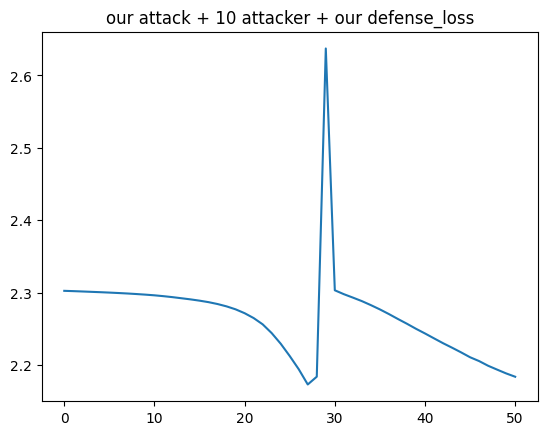

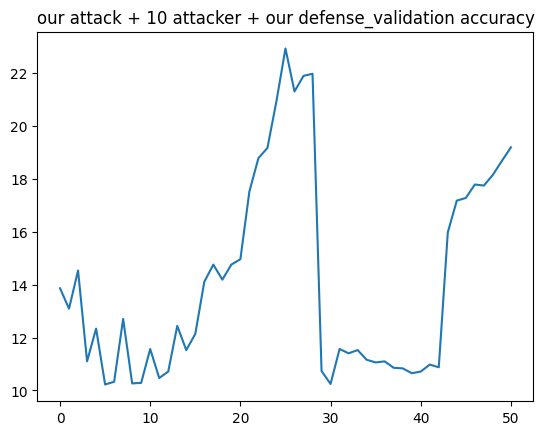

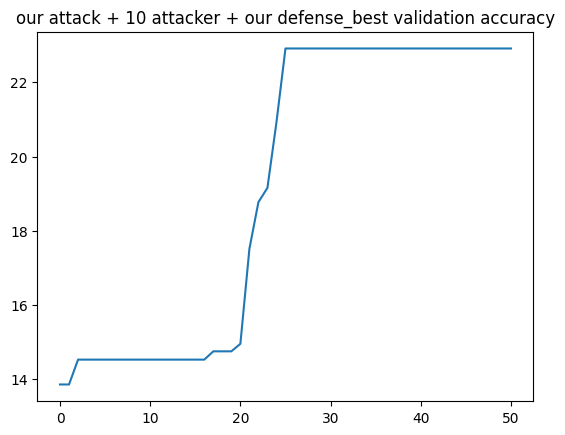

In [13]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./our attack + 10 attacker + our defense ' + col + '.png')
    plt.show()

## Execute no attack + our defense

In [ ]:
batch_size=250
resume=0

nepochs= 500

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[0]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size
            # nbatches = 1000//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            # inputs = user_train_data_tensors[i]
            # targets = user_train_label_tensors[i]

            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad ()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                # print(param.shape)
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])
       
        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//n_users)
            agg_grads = torch.mean(user_grads[:n_attacker], 0)

            # No attack
            # malicious_grads = user_grads

            # Attack
            mal_updates = our_attack_mean_std(user_grads, agg_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])

        #remove when attacker not 0    
        malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
        
        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)
        for i in range(n_users):
            history[i].extend(updates_abs_mean[i])        

        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no_attack.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./no attack + our defense ' + col + '.png')
    plt.show()

## Execute our attack + 10 attacker + bulyan

In [ ]:
batch_size=250
resume=0

nepochs= 500

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size
            # nbatches = 1000//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            # inputs = user_train_data_tensors[i]
            # targets = user_train_label_tensors[i]

            targets = targets.type(torch.LongTensor)   
            
            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                # print(param.shape)
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])
       
        if n_attacker > 0:
            n_attacker_ = max(1, n_attacker**2//n_users)
            agg_grads = torch.mean(user_grads[:n_attacker], 0)

            # Attack
            mal_updates = our_attack_mean_std(user_grads, agg_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)
        
        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)
        for i in range(n_users):
            history[i].extend(updates_abs_mean[i])        

        if  torch.isnan(updates_abs_mean).any():
            print("updates_abs_mean contains a nan value")
            nan_indices = torch.where(torch.isnan(updates_abs_mean))
            print("updates_abs_mean has nan value at these index: ", nan_indices)
            user_grad_nan_index = torch.where(user_grads[nan_indices[0]])
            print("user_grads has nan value at these index", user_grad_nan_index)
            print(user_grads[nan_indices[0]][user_grad_nan_index])
            print(user_grads[nan_indices[0]][user_grad_nan_index].shape)
 
        agg_grads, _ = bulyan(malicious_grads, n_attacker)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc

        
        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num, 
            'loss': val_loss, 
            'validation accuracy': val_acc, 
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no_attack.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break
            
        epoch_num+=1

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("Execute our attack + 10 attacker + bulyan_"+col)
    plt.savefig('./our attack + 10 attacker + bulyan ' + col + '.png')
    plt.show()